In [28]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#Run the below piece of code for the first time
#nltk.download('stopwords')

In [29]:
dialogs_data = pd.read_csv("dialog_lines.csv",encoding = "UTF8")
dialogs_data.head()

,racist/not_racist,dialog_line
0,not_racist,\n\n\n\n\n
1,not_racist,GRAN TORINO\n\n\n\n ...
2,not_racist,FADE IN\n\n\n\n INT CHURCH\n\n\n ...
3,not_racist,Walt She was a real peach\n\n\n
4,not_racist,WALT\n\n Thanks for coming Al\n ...


In [30]:
dialogs_data.groupby('racist/not_racist').describe()


dialog_line                                     
                        count unique                      top freq
racist/not_racist                                                 
not_racist              38014  32277  \n\n                     304
racist                   1377   1371          BEMBRY \n\n\t\t    4

In [31]:
#dialogs_data.groupby('racist/not_racist').describe()

nrd = dialogs_data[dialogs_data['racist/not_racist'] == 'not_racist'].sample(1377)
rd = dialogs_data[dialogs_data['racist/not_racist'] == 'racist']

dialogs_data = pd.concat([nrd, rd])
dialogs_data.groupby('racist/not_racist').describe()


dialog_line                             
                        count unique              top freq
racist/not_racist                                         
not_racist               1377   1297             PAUL   10
racist                   1377   1371  BEMBRY \n\n\t\t    4

In [32]:
dialogs_data_copy = dialogs_data['dialog_line'].copy()


In [33]:
def text_preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

In [34]:
dialogs_data_copy = dialogs_data_copy.apply(text_preprocess)

In [35]:
dialogs_data_copy

720                                                       
32500                        Well Fine think Ill keep rest
5000                                          thing Branca
6825                                              Famously
31581    two men ride horses road leads front steps Ben...
                               ...                        
39137                               Im dime dozen MACREEDY
39146         said Im first black guy youd ever dated ROSE
39263                               Im bitch ass nigga huh
39283    Would network really run without interview WAY...
39373    first let suck line coke FRANK Thats Im Jackie...
Name: dialog_line, Length: 2754, dtype: object

In [36]:
vectorizer = TfidfVectorizer()

In [37]:
dialogs_mat = vectorizer.fit_transform(dialogs_data_copy)
dialogs_mat

<2754x8549 sparse matrix of type '<class 'numpy.float64'>'
	with 34490 stored elements in Compressed Sparse Row format>

In [38]:
dialogs_train, dialogs_test, r_nr_train, r_nr_test = train_test_split(dialogs_mat, 
                                                        dialogs_data['racist/not_racist'], test_size=0.3, random_state=20)


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
#solver='liblinear', penalty='l1'
racist_model = LogisticRegression()
racist_model.fit(dialogs_train, r_nr_train)
pred = racist_model.predict(dialogs_test)
accuracy_score(r_nr_test,pred)
print("Accuracy:",metrics.accuracy_score(r_nr_test,pred))


Accuracy: 0.8778718258766627


# Bootstrapping

In [40]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

In [41]:
accuracy = []
n_iterations = 1000
for i in range(n_iterations):
    X_bs, y_bs = resample(dialogs_train, r_nr_train, replace=True)
    # make predictions
    y_hat = racist_model.predict(X_bs)
    # evaluate model
    score = accuracy_score(y_bs, y_hat)
    accuracy.append(score)

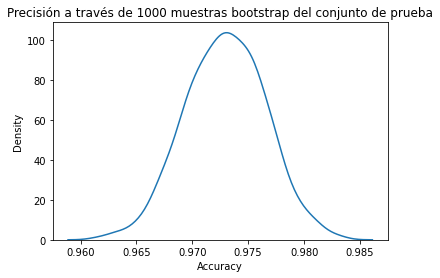

In [42]:
import seaborn as sns
# plot distribution of accuracy
sns.kdeplot(accuracy)
plt.title("Precisión a través de 1000 muestras bootstrap del conjunto de prueba")
plt.xlabel("Accuracy")
plt.show()


## Matriz de confusión sobre Bootstrapping

In [43]:
from sklearn import metrics

n_iterations = 10000
for i in range(n_iterations):
    X_bs, y_bs = resample(dialogs_train, r_nr_train, replace=True)

    score = accuracy_score(y_bs, y_hat)
    # make predictions
    y_hat = racist_model.predict(X_bs)

print("Accuracy:", score)
cnf_matrix_bootstrap = metrics.confusion_matrix(y_bs, y_hat)
cnf_matrix_bootstrap

Accuracy: 0.5070057083549558


array([[950,  21],
       [ 11, 945]])

Text(0.5, 257.44, 'Predicted label')

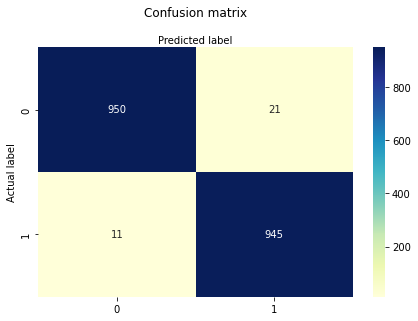

In [44]:
class_names=["not_racist","racist"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_bootstrap), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Analizando el modelo

In [45]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(r_nr_test, pred)
cnf_matrix

array([[388,  37],
       [ 64, 338]])

In [47]:

r_nr_test = np.array(list(map(lambda s: 0 if s == "not_racist" else 1, r_nr_test)))

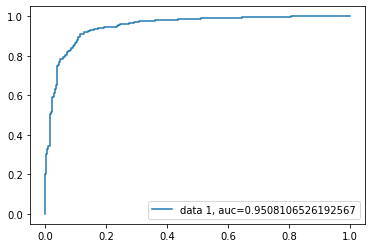

In [48]:
y_pred_proba = racist_model.predict_proba(dialogs_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(r_nr_test,  y_pred_proba)
auc = metrics.roc_auc_score(r_nr_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5, 257.44, 'Predicted label')

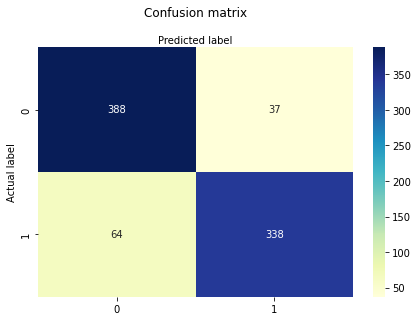

In [49]:
class_names=["not_racist","racist"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')